In [1]:
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString, box
import random
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd

In [2]:
with open('sample.geojson', 'r', encoding='windows-1251') as f:
    data = json.load(f)

print(json.dumps(data, ensure_ascii=False, indent=4))

{
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [
                            39.787879,
                            57.44876
                        ],
                        [
                            39.789041,
                            57.448078
                        ],
                        [
                            39.794747,
                            57.450329
                        ],
                        [
                            39.791648,
                            57.450982
                        ],
                        [
                            39.787879,
                            57.44876
                        ]
                    ]
                ]
            },
            "properties": {
                "name": "Зона застройки"
            }
     

In [3]:
def Create_gdf(data:dict):

    '''Функция получает на вход данные в формате dict и возвращает геодатасет с размеченными областями'''

    geometries = []
    names = []
    restrictions = []

    for feature in data['features']: # Итерируем по фичам
        geom_type = feature['geometry']['type'] # Тип области
        restriction = feature['properties'].get('restriction', None) # Получаем ограничение на область. Если ограничений нет - None

        if geom_type == 'Polygon': # Для полигонов
            coords = feature['geometry']['coordinates'][0] # Получаем координаты
            polygon = Polygon([(lon, lat) for lon, lat in coords]) # Создаем полигон шейпли по координатам
            geometries.append(polygon) # Тут и ниже - собираем строку для gdf
            names.append(feature['properties']['name'])
            restrictions.append(restriction)
        elif geom_type == 'LineString': # Аналогично для линий
            coords = feature['geometry']['coordinates']
            line = LineString([(lon, lat) for lon, lat in coords])
            geometries.append(line)
            names.append(feature['properties']['name'])
            restrictions.append(restriction)
    res = gpd.GeoDataFrame({'geometry' : geometries, 'name' : names, 'restrictions' : restrictions})

    return res

In [4]:
gdf = Create_gdf(data)
gdf

,geometry,name,restrictions
0,"POLYGON ((39.78788 57.44876, 39.78904 57.44808...",Зона застройки,None
1,"POLYGON ((39.78759 57.45067, 39.78954 57.44924...",Лесная зона,building not allowed
2,"POLYGON ((39.78659 57.44999, 39.78977 57.44868...",Водоем,building not allowed
3,"LINESTRING (39.78752 57.45061, 39.79018 57.450...",Дорога,building not allowed


In [5]:
def Plot_empty(gdf:gpd.GeoDataFrame, width:int=20, height:int=40):

    '''Функция получает на вход датасет в формате GeoDataFrame и отрисовывает зоны, хранящиеся в нем.
    Обязательные полня в датасете:
    geometry - зоны в формате geometry
    name - названия зон
    restrictions - ограничения на строительства
    На выходе строит карту полученных зон'''

    fig, ax = plt.subplots(figsize=(width, height))

    # Собираем зоны. Концептуальный пример, для реальной работы и зон и признаков будет больше, как я думаю
    forest_zone = gdf[(gdf['geometry'].type == 'Polygon') & (gdf['restrictions'].notnull()) & (gdf['name'] == 'Лесная зона')]
    water_zone = gdf[(gdf['geometry'].type == 'Polygon') & (gdf['restrictions'].notnull()) & (gdf['name'] == 'Водоем')]
    building_zone = gdf[(gdf['geometry'].type == 'Polygon') & (gdf['restrictions'].isnull())]
    roads = gdf[gdf['geometry'].type == 'LineString']

    # Плотим зомы
    forest_zone.plot(ax=ax, color='red', edgecolor='black', legend=False, alpha=0.5)
    water_zone.plot(ax=ax, color='blue', edgecolor='black', legend=False, alpha=0.5)
    roads.plot(ax=ax, color='black', linewidth=4, legend=False)
    building_zone.plot(ax=ax, color='lightgreen', edgecolor='black', legend=False, alpha=0.5)

    # Задаем легенду
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label='Лесная зона', markerfacecolor='red', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Водоем', markerfacecolor='blue', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Зоны застройки', markerfacecolor='lightgreen', markersize=10),
        plt.Line2D([0], [0], color='black', linewidth=3, label='Дороги')
    ]

    ax.legend(handles=handles)
    ax.set_title('План зон')
    ax.set_xlabel('Долгота')
    ax.set_ylabel('Широта')
    plt.grid()
    plt.show()

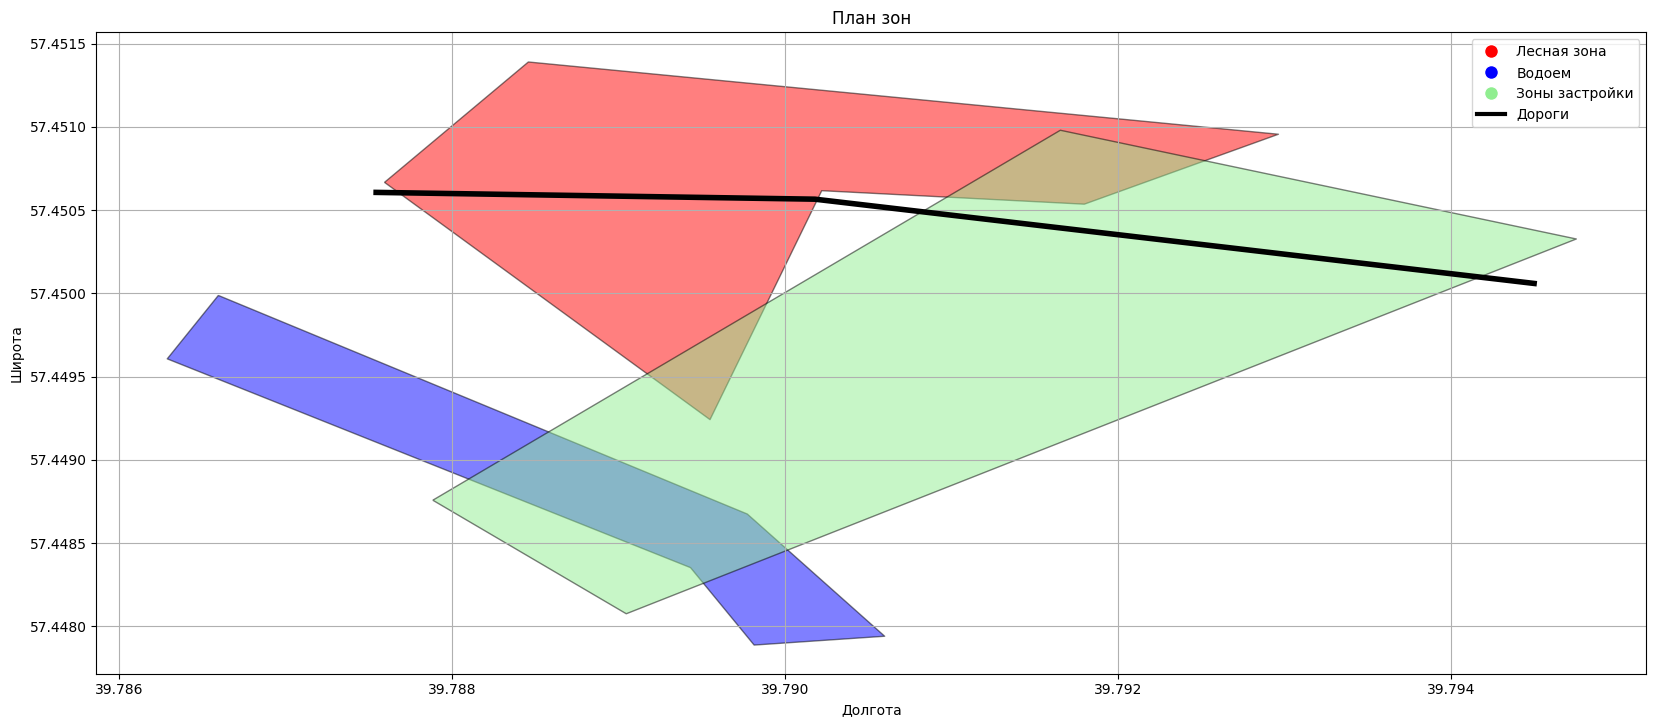

In [6]:
Plot_empty(gdf)

In [7]:
allowed_percent = 0.40

# Расчет площади участка и допустимой площади для застройки
total_area = gdf[gdf['name'] == 'Зона застройки']['geometry'].area.values[0]
allowed_area = total_area * allowed_percent

restricted_zones = gdf[gdf['name'] != 'Зона застройки']['geometry']

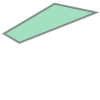

In [13]:
total_area = gdf[gdf['name'] == 'Зона застройки']['geometry'][0]
total_area

In [9]:
restricted_zones

1    POLYGON ((39.78759 57.45067, 39.78954 57.44924...
2    POLYGON ((39.78659 57.44999, 39.78977 57.44868...
3    LINESTRING (39.78752 57.45061, 39.79018 57.450...
Name: geometry, dtype: geometry

In [26]:
other_zones_gdf = restricted_zones
total_zone = gdf[gdf['name'] == 'Зона застройки']['geometry'][0]

def generate_square_in_polygon(polygon, square_size, other_zones_gdf, max_attempts=100):
    for attempt in range(max_attempts):
        # Генерируем случайные координаты внутри ограничивающего прямоугольника полигона
        minx, miny, maxx, maxy = polygon.bounds
        x = random.uniform(minx, maxx - square_size)  # Убедитесь, что квадрат помещается
        y = random.uniform(miny, maxy - square_size)

        # Создаём квадрат
        square = box(x, y, x + square_size, y + square_size)

        # Проверяем, лежит ли квадрат внутри полигона
        if polygon.contains(square):
            # Проверяем, пересекается ли квадрат с другими зонами
            if not other_zones_gdf.geometry.intersects(square).any():
                return square
    
    # Если не удается создать квадрат, вернуть None или обработать по-другому
    return None

# Параметры квадрата
square_size = 0.0001  # размер стороны квадрата в метрах

# Создаем два квадрата
squares = []
for _ in range(1000):
    square = generate_square_in_polygon(total_zone, square_size, other_zones_gdf)
    if square:  # Проверяем, был ли успешно сгенерирован квадрат
        squares.append(square)
    else:
        print("Не удалось разместить квадрат в пределах полигона.")

# Создаем GeoDataFrame для квадратов (если удалось разместить)
squares_gdf = gpd.GeoDataFrame(geometry=squares, crs=gdf.crs)
squares_gdf['name'] = 'Дом'
squares_gdf['restrictions'] = None  # В случае, если для домов нет ограничений

# Объединяем со старым GeoDataFrame
final_gdf = pd.concat([gdf, squares_gdf], ignore_index=True)

# Для подтверждения, можно вывести результат
print(final_gdf)


                                               geometry            name  \
0     POLYGON ((39.78788 57.44876, 39.78904 57.44808...  Зона застройки   
1     POLYGON ((39.78759 57.45067, 39.78954 57.44924...     Лесная зона   
2     POLYGON ((39.78659 57.44999, 39.78977 57.44868...          Водоем   
3     LINESTRING (39.78752 57.45061, 39.79018 57.450...          Дорога   
4     POLYGON ((39.78857 57.44844, 39.78857 57.44854...             Дом   
...                                                 ...             ...   
999   POLYGON ((39.7932 57.45042, 39.7932 57.45052, ...             Дом   
1000  POLYGON ((39.79006 57.44918, 39.79006 57.44928...             Дом   
1001  POLYGON ((39.792 57.44945, 39.792 57.44955, 39...             Дом   
1002  POLYGON ((39.79091 57.44899, 39.79091 57.44909...             Дом   
1003  POLYGON ((39.79075 57.45007, 39.79075 57.45017...             Дом   

              restrictions  
0                     None  
1     building not allowed  
2     buildi

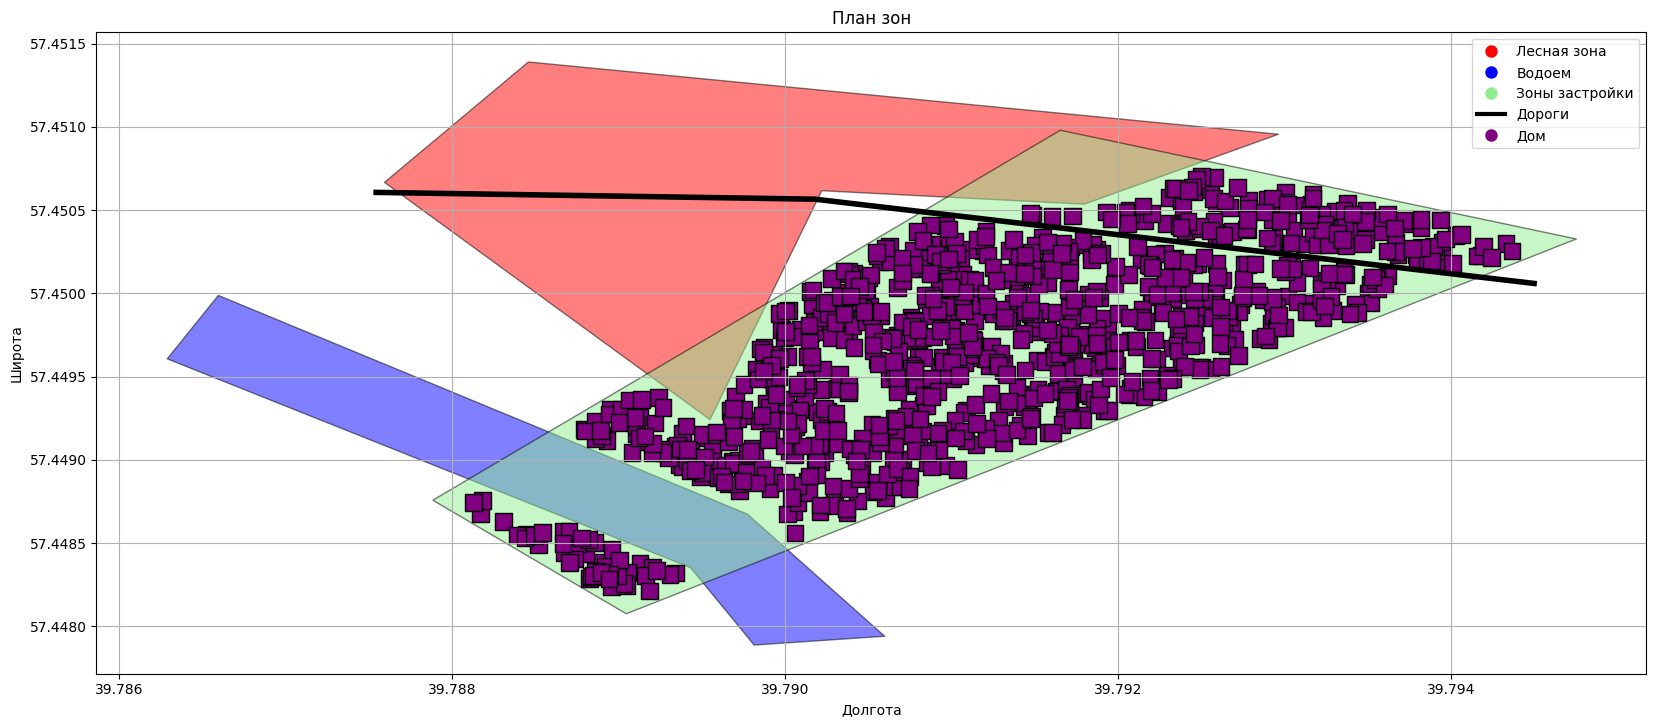

In [27]:
fig, ax = plt.subplots(figsize=(20, 40))

# Собираем зоны. Концептуальный пример, для реальной работы и зон и признаков будет больше, как я думаю
forest_zone = final_gdf[(final_gdf['geometry'].type == 'Polygon') & (final_gdf['name'] == 'Лесная зона')]
water_zone = final_gdf[(final_gdf['geometry'].type == 'Polygon') & (final_gdf['name'] == 'Водоем')]
building_zone = final_gdf[(final_gdf['geometry'].type == 'Polygon') & (final_gdf['name'] == 'Зона застройки')]
roads = final_gdf[final_gdf['geometry'].type == 'LineString']
houses = final_gdf[(final_gdf['geometry'].type == 'Polygon') & (final_gdf['name'] == 'Дом')]

# Плотим зомы
forest_zone.plot(ax=ax, color='red', edgecolor='black', legend=False, alpha=0.5)
water_zone.plot(ax=ax, color='blue', edgecolor='black', legend=False, alpha=0.5)
roads.plot(ax=ax, color='black', linewidth=4, legend=False)
building_zone.plot(ax=ax, color='lightgreen', edgecolor='black', legend=False, alpha=0.5)
houses.plot(ax=ax, color='purple', edgecolor='black', legend=False)

# Задаем легенду
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Лесная зона', markerfacecolor='red', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Водоем', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Зоны застройки', markerfacecolor='lightgreen', markersize=10),
    plt.Line2D([0], [0], color='black', linewidth=3, label='Дороги'),
    plt.Line2D([0], [0], marker='o', color='w', label='Дом', markerfacecolor='purple', markersize=10)
]

ax.legend(handles=handles)
ax.set_title('План зон')
ax.set_xlabel('Долгота')
ax.set_ylabel('Широта')
plt.grid()
plt.show()